In [37]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

wrkdir = '/home/arsalikhov/Documents/PSYCH420_final_project/'

In [127]:
dataDir='/media/gamedisk/COCO_dataset'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [128]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=10.49s)
creating index...
index created!


In [129]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



In [136]:
classes = [
    "bird"
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe"
]

In [135]:
catIds = coco.getCatIds(catNms=['dog'])
imgIds = coco.getImgIds(catIds=catIds )
catsIDS = []
catsAnnotations = []
for i in range(len(imgIds)):
    img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    anns = coco.annToMask(anns[0])
    catsIDS.append(img)
    catsAnnotations.append(anns)
len(imgIds)

4385

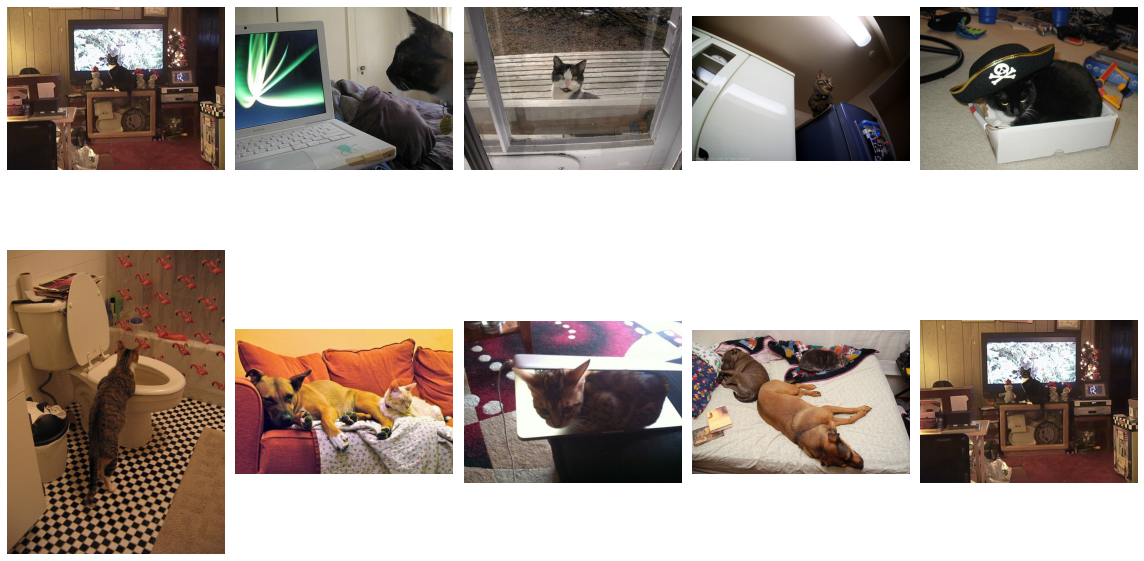

In [114]:

w = 10
h = 10
fig = plt.figure(figsize=(16,  10))
columns = 5
rows = 2
for i in range(1, len(catsIDS)):
    I = io.imread(catsIDS[i]['coco_url'])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(I)
plt.tight_layout()
plt.savefig(wrkdir + "/tex/Images/cats.png")
plt.show()




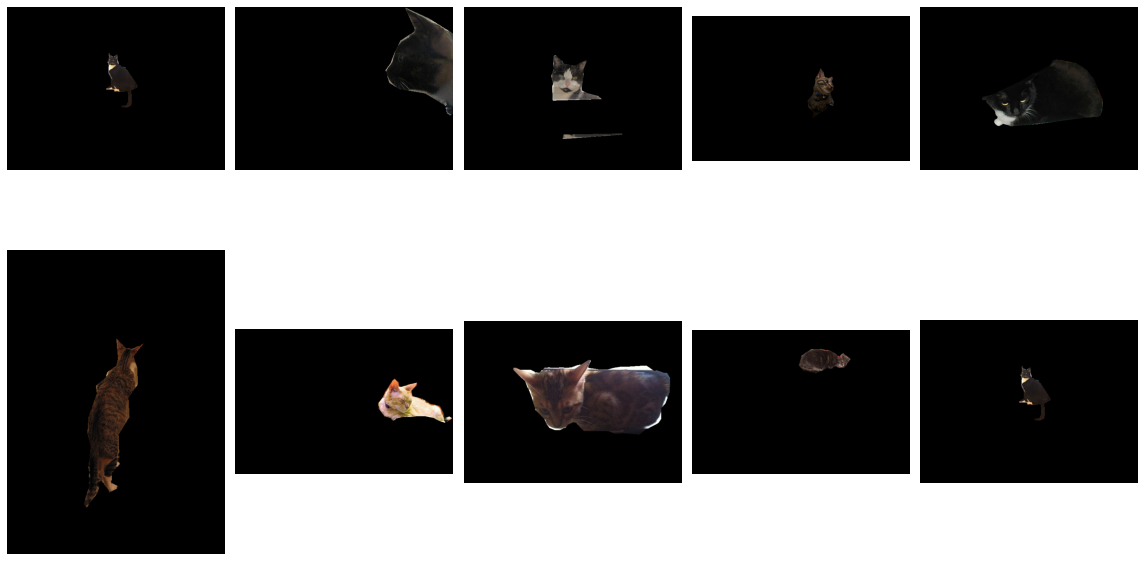

In [122]:
import cv2

w = 10
h = 10
fig = plt.figure(figsize=(16,  10))
columns = 5
rows = 2

for i in range(1, len(catsIDS)):
    I = io.imread(catsIDS[i]['coco_url'])
    anns = cv2.cvtColor(catsAnnotations[i],cv2.COLOR_GRAY2RGB)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(I*anns)

plt.tight_layout()
plt.savefig(wrkdir + "/tex/Images/hidden_cats.png")
plt.show()


- 8 conv layers
- 8 spiking (lif) layers

- architecture similar to U-Net

input -> LIF(conv) (5x5x32)? -> lif -> conv2

encoder(model) -> decoder(model)


In [40]:
import torch, torch.nn as nn
import snntorch as snn
import numpy as np
import random as r
import torchvision
from snntorch import surrogate

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda:0


In [44]:
batch_size = 128
alpha = 0.9
beta = 0.85
spike_grad = surrogate.fast_sigmoid(slope=25)
num_steps = 100

In [60]:
class Model(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, 4)
        self.lif1 = snn.Leaky(beta = beta)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta = beta)

    

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        
        for step in range(num_steps):
            cur1 = self.conv1(x)
            spk1, mem1 = self.lif1(cur1,mem1)
            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            print(spk2.shape)
            cur3 = self.fc1(spk2.view(1600, -1))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec), torch.stack(mem3_rec)        

class Encode(nn.Module):
    def __init__(self, channels  = (1, 2, 3, 16)):
        super().__init__()
        self.enc_models = nn.ModuleList([Model(channels[k], channels[k+1]) for k in range(len(channels)-1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, a):
        features = [] 
        for model in self.enc_models:
            a = model(a)
            features.append(a)
            print(a[1].shape)
            a = self.pool(a[0])
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(16, 3, 2, 1)):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(channels[k], channels[k+1], 3, 3) for k in range(len(channels)-1)])
        self.dec_models = nn.ModuleList([Model(channels[k], channels[k+1]) for k in range(len(channels)-1)])
    
    def forward(self, a, encodedata_features):
        for k in range(len(self.channels)-1):
            a = self.upconvs[k](a)
            enc_features = self.crop(encodedata_features[k], a)
            a = torch.cat([a, enc_features], dim=1)
            a = self.dec_models[k](a)
        return a

    def crop(self, enc_features, a):
        _, _, H, W = a.shape
        enc_features = torchvision.transforms.CenterCrop([H, W])(enc_features)
        return enc_features

In [61]:
decoder = Decoder().to(device)
encodedata = Encode().to(device)
a = torch.randn(1, 1, 12, 12)
a = a.to(device)
features = encodedata(a)
decoder(a, features[::-1][1:]).shape

torch.Size([1, 64, 5, 5])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1600x1 and 1600x1)